<h1>Scientific coding bootcamp notebook 4: Fourier analysis and the FFT.</h1>

The big idea of Fourier analysis is that complex exponentials like $e^{2πinx}$ ($n$ fixed, $x$ a variable) for an orthogonal basis for many interesting function spaces.  The change of basis operation for representing a function in this basis is some sort of "Fourier transform", though the exact nature (and name) of this operation depends on whether you are working with $x$ continuous vs. discrete and bounded vs. unbounded.  Here's a table of the different cases: 


|  | Discrete | Continuous |
| :-: | :-: | :-: |
| **Bounded** | DFT | Fourier series |
| **Unbounded** | z-transform | Fourier transform |

We will start with Fourier series, as they are maybe the easiest to understand, but our main goal is the fully discrete case (DFT, which stands for "Discrete Fourier Transform"), as this is the most relevant for numerical work.

<h2>Fourier series</h2>

In all versions of Fourier analysis, the key questions are "What is the vector space?" and "What is the inner product?".  For Fourier series, the vector space is functions on some bounded interval, which will always take to be the unit interval $[0,1]$.  The inner product is the obvious one,
$$
\langle f |g \rangle := \int_0^1 f(x) g^*(x) dx.
$$

In this setting, complex exponentials like $e^{2πinx}$, with $n$ an integer, form an orthonormal basis for periodic 1D functions on the unit interval $[0,1]$.  That is,
$$
\int_0^1 e^{2\pi i n x} e^{-2\pi i m x} dx = \delta_{nm}.
$$
Let's expand some functions on $[0,1]$ with respect to this basis to see how it works. 

In [121]:
using FFTW, Plots, LaTeXStrings

In [122]:
const Lattice = AbstractRange

function expOverlap(grid::Lattice,f::Vector{T},n::Real) where {T<:Number}
    integrand = f .* exp.(-2π*im*grid*n)
    return sum(integrand) * step(grid)
end

expOverlap (generic function with 1 method)

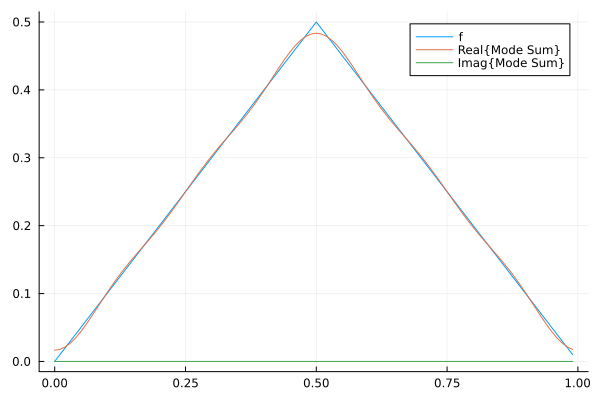

In [123]:
#= Fill in the code below to decompose the function f as a sum of complex exponentials.  
Check that it matches f reasonably well, and experiment with different grid spacings dx and numbers of modes. 
=#
dx = 0.01
grid = 0:dx:1-dx/2
f = (x -> x < 0.5 ? x : 1.0-x).(grid)      # The  "... ? ... : ..." is called a ternary operator.  Look up how it works if it's unfamiliar.
modes = -5:5
coeffs = [expOverlap(grid,f,n) for n in modes]  # Your code here.
plot(grid,f,label="f")
plot!(grid,real.(sum(exp.(2pi*im*grid*modes[n])*coeffs[n] for n=1:length(modes))),label="Real{Mode Sum}")
plot!(grid,imag.(sum(exp.(2pi*im*grid*modes[n])*coeffs[n] for n=1:length(modes))),label="Imag{Mode Sum}")

In [18]:
#= Repeat the above for the following functions:
f = (x -> sin(2pi*x^2)).(grid)
f = (x -> x < 0.5 ? 1.0 : 0.0).(grid)    # This is called a square wave. 
=#

In [ ]:
#= For the square wave function f, see what happens as you increase the number of modes from -40:40 to -50:50 to -80:80
at a step size of dx=0.01. Then make the grid spacing smaller and repeat.  
(The wiggles at the jumps are called Gibbs' phenomenon, and are not the main interest here.) 
Can you understand the behavior you observe in terms of the dimension of the relevant vector space? 
=#

<h2>Discrete Fourier Transform</h2>

When we expanded the square wave, we saw some numerical artifacts due to the fact that we are discretizing continuous integrals onto finite grids.  A convenient way to deal with this is to treat functions and integrals as discrete from the start.  That is, instead of functions $f(x)$ of a continuous variable $x\in [0,1]$, we consider *sequences* $f_j = f(x_j)$ of the functions' values sampled at a grid of points $x_j = j/N$, $j=0,1,\dots,N-1$.  Then instead of integrals $\int_0^1 f(x) dx$, we consider sums $\sum_{j=0}^N f_j$. 

Sampled complex exponentials are still orthonormal in the following sense: 
$$
\frac{1}{N}\sum_{j=0}^N e^{2\pi i n j/N} e^{-2\pi i m j/N} = \delta_{nm}.
$$
This means we can use sampled complex exponentials of this form as a basis for sequences of length $N$. 

**Question:** How many such complex exponentials are needed to form a basis?  What can you say about the linear dependence of a collection of complex exponentials with more than this number? 

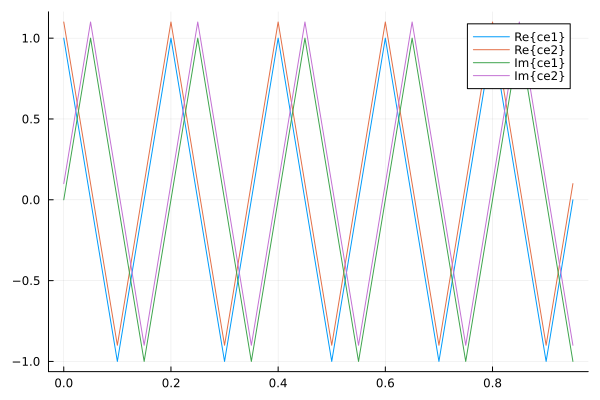

In [124]:
#= Plot exp.(2pi * im * n * j/N) for some reasonable value of N and several values of n.  
Find some minimal collection of n's which form a linearly dependent set.  
What is the linear dependence relationship?
=#

N = 20 
xs = (0:N-1) ./ N
n = 5
ce1 = exp.(2pi * im * n * xs)
ce2 = exp.(2pi * im * (n+N) * xs)
plot(xs,[real.(ce1),real.(ce2).+0.1,imag.(ce1),imag.(ce2).+0.1],labels=["Re{ce1}" "Re{ce2}" "Im{ce1}" "Im{ce2}"])

Two complex exponentials $e^{2\pi i n j/N}$ with different frequencies (i.e. different values of $n$) which have the same values at all grid points are called *aliases* of each other.  For which values of $n$ does $e^{2\pi i n j/N}$ have an alias $e^{2\pi i m j/N}$ with $|m| < |n|$? 

This is essentially the content of the "Whittaker–Nyquist–Shannon sampling theorem".  It says that if you want to accurately measure a function with frequency $f$, you need to sample it at a rate of at least $2f$.  Otherwise, the function will be *aliased*, which means it will look like a lower frequency function. 

(The full theorem goes a bit further and talks about perfectly reconstructing functions with bounded frequency content using infinitely many samples.  I don't find this particularly useful in practice.)

<h3>DFT as a unitary matrix.</h3>

Complex exponentials $\frac{1}{\sqrt{N}} e^{2\pi i n j/N}$, $n=0,\dots,N-1$, form an orthonormal basis (the "Fourier basis") for length $N$ sequences.  Another orthonormal basis is the "Dirac basis" $\delta_{nj}$, $n=0,\dots,N-1$.  We are thinking of $\delta_{nj}$ here as a sequence of length $N$, with a $1$ in the $n$-th slot and zeros everywhere else.  E.g. 
$$
\delta_{2,j} = (0,0,1,0,0,\dots,0,0,0)
$$
When you write a sequence as $(f_0, f_1, \dots, f_{N-1})$, you are effectively giving its coefficients with respect to the Dirac basis.  To expand the same function in the complex exponential basis as 
$$
f_j = \sum_n c_n \frac{1}{\sqrt{N}} e^{2\pi i n j / N}
$$
you can compute $c_n$ via the overlap sum 
$$
c_n = \sum_j f_j \frac{1}{\sqrt{N}} e^{-2\pi i n j/N}.
$$
Alternatively, we can compute a change of basis matrix $U$ with entries $$U_{nm} = \sum_j \delta_{nj} \frac{1}{\sqrt{N}} e^{-2\pi i m j/N} = \frac{1}{\sqrt{N}} e^{-2\pi i m n / N}.$$  Note that this is the matrix of inner products between the Dirac basis and the Fourier basis.  In terms of this matrix, the coefficients of $(f_0, f_1, \dots, f_{N-1})$ are just 
$$
\begin{bmatrix}
           c_0 \\ c_1 \\ \vdots \\ c_{N-1}
         \end{bmatrix} = U \begin{bmatrix}
           f_0 \\ f_1 \\ \vdots \\ f_{N-1}
         \end{bmatrix}.
$$

**Problem:** Justify this equation. 

In [126]:
#= Compute the U matrix for N=9 and use it to get the Fourier coefficients of sin(4pi * x), 
where x is sampled on 0:1/9:8/9.
Check that the result makes sense analytically by writing sin(4pi * x) as a 
sum of complex exponentials directly (Euler's formula). 
=#
xs = 0:1/9:8/9
fs = sin.(4pi * xs)
N = length(xs)
U = [exp(-2π * im * n * m / N)/sqrt(N) for n=0:N-1,m=0:N-1]
cs = U * fs
round.(cs,digits=3)

9-element Vector{ComplexF64}:
  0.0 + 0.0im
 -0.0 + 0.0im
  0.0 - 1.5im
  0.0 + 0.0im
 -0.0 + 0.0im
  0.0 + 0.0im
 -0.0 + 0.0im
 -0.0 + 1.5im
  0.0 - 0.0im

This makes sense, because 
$$
\sin(4\pi x_j) = \frac{1}{2i}\left(e^{4\pi x_j} - e^{-4\pi x_j}\right) = -1.5 i \times \frac{1}{\sqrt{9}} e^{2\pi i 2 j/N} + 1.5 i \times \frac{1}{\sqrt{9}} e^{2\pi i (-2) j/N}.
$$
Up to some numerical rounding errors, the coefficients we got were $c_2 = -1.5 i$, $c_{N-2} = 1.5 i$, and all other $c_j=0$.  Note that $c_{N-2}$ represents the coefficient of $e^{2\pi i (-2) j /N}$ due to aliasing. 

The process of changing from the Dirac basis to the Fourier basis is called the "Discrete Fourier Transform" or DFT.  As a point of nomenclature, "DFT" usually refers to the coefficient formula 
$$
c_n = \sum_j f_j \frac{1}{\sqrt{N}} e^{-2\pi i n j/N},
$$
but it could just as well refer to the matrix $U$.  

<h2>Fast Fourier Transform (FFT)</h2>

Computing the DFT via overlap integrals or via the matrix $U$ can be slow for large sampling grids.  It turns out there is a much faster way to compute it, called the Fast Fourier Transform (FFT).  We won't get into how it works (look it up!), but we will see that it does work. 

An important note about FFT implementations is that there are several conventions for how they are normalized.  The standard Julia FFT implementation differs from the convention we used above by a factor of $1/\sqrt{N}$.  That is, `U * fs = fft(fs)/sqrt(N)`. 

In [80]:
cs2 = fft(fs)/sqrt(N)

9-element Vector{ComplexF64}:
 3.3306690738754696e-16 + 0.0im
  3.700743415417188e-17 + 2.1828966327425064e-16im
 -4.766725129728141e-16 - 1.5im
 1.6653345369377348e-16 - 1.6024689053196365e-16im
 1.0340723218667514e-16 - 3.754941650780661e-18im
 1.0340723218667514e-16 + 3.754941650780661e-18im
 1.6653345369377348e-16 + 1.6024689053196365e-16im
 -4.766725129728141e-16 + 1.5im
  3.700743415417188e-17 - 2.1828966327425064e-16im

In [81]:
# Let's see how fast the FFT is compared to the matrix multiplication DFT method. 
using BenchmarkTools
N = 1000
xs = 0:1/N:1-1/N
fs = sin.(4pi * xs)
U = [exp(-2π * im * n * m / N)/sqrt(N) for n=0:N-1,m=0:N-1];

In [82]:
@benchmark U*fs

BenchmarkTools.Trial: 5097 samples with 1 evaluation.
 Range (min … max):  372.300 μs … 101.046 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     656.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   939.137 μs ±   1.567 ms  ┊ GC (mean ± σ):  0.17% ± 1.04%

    ▂▇█▇▆▆▅▄▄▃▂▂▁                                ▁▂▁            ▂
  ▇▇█████████████████████▇▇▆▇██▇▇██▇▇▇▇▇▇▇▇▆▆▆▇▇████▇█▆▄▄▄▂▂▄▂▄ █
  372 μs        Histogram: log(frequency) by time       3.29 ms <

 Memory estimate: 31.50 KiB, allocs estimate: 2.

In [83]:
@benchmark fft(fs) ./ sqrt(N)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.800 μs …   9.355 ms  ┊ GC (min … max): 0.00% … 66.16%
 Time  (median):     55.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   73.335 μs ± 203.581 μs  ┊ GC (mean ± σ):  4.84% ±  1.93%

  ▃▃▃▃▆▆▃▂▂█▅▄▄▃▃▂▂▂▄▄▂▂▁▁▁                                    ▂
  ██████████████████████████████████▇▇▆▆▆▅▆▆▆▅▄▆▆▆▆▆▅▅▅▆▆▆▆▆▃▅ █
  12.8 μs       Histogram: log(frequency) by time       281 μs <

 Memory estimate: 47.59 KiB, allocs estimate: 9.

<h2>Appications of FFT.</h2>

<h3>(De)Convolution.</h3>

A common application of FFTs is fast (de)convolution. Suppose we have an image $I_{jk}$, $j,k=0,1,\dots,N-1$, that we want to blur.  A way to accomplish this is to replace each pixel by the average of the neighboring pixels, out to a distance $n$ in each direction (wrapping around at the boundary).  This is called convolution, and it can be written mathematically as 
$$
(I*K)_{jk} = \sum_{pq} I_{j-p,k-q} K_{pq},
$$
where the *kernel* $K_{pq} = \frac{1}{(2n+1)^2}$ if $j,k$ lie in a box of side length $2n+1$ centered at $(0,0)$ and wrapping around boundaries.  In the sum $I_{j-p,k-q}$ is also extended periodically when the indices go outside of the range $[0,N-1]$.  

According to the *convolution theorem*, the convolution $I*K$ can also be computed using FFTs: 
$$
(I*K)_{jk} = \text{ifft}(\text{fft}(I) \text{ .* } \text{fft}(K))_{jk},
$$
where $\text{ifft}$ is the inverse FFT, and the product is taken pointwise.  Note that an FFT of a 2D grid is just an FFT along rows followed by another FFT along columns.

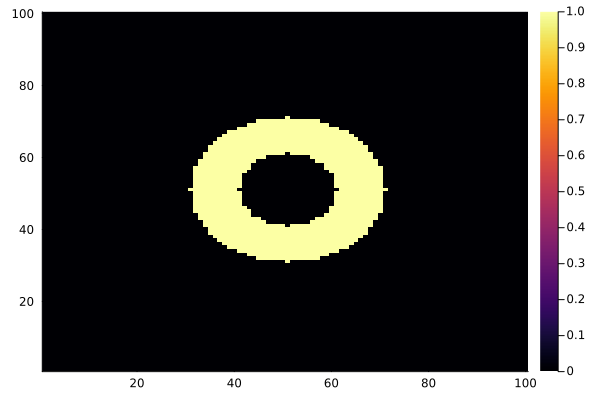

In [97]:
N = 100
dx = 1/N
grid = (0:dx:1-dx,0:dx:1-dx)
I = [(0.1 <= sqrt((x-1/2)^2 + (y-1/2)^2) <= 0.2 ? 1.0 : 0.0) for x in grid[1], y in grid[2]]
heatmap(I)

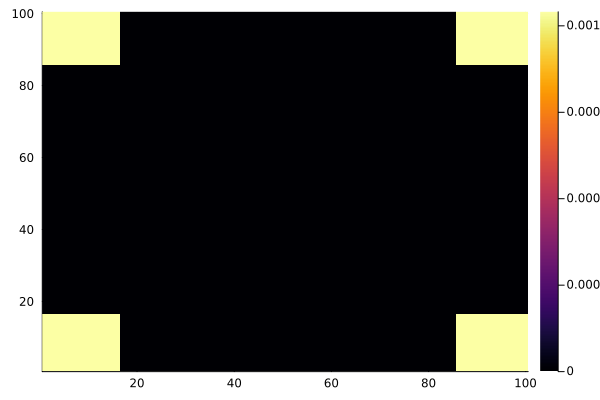

In [99]:
n = 15
K = [(j <= n || j >= N-n) && (k <= n || k >= N-n) ? 1.0 : 0.0 for j=0:N-1,k=0:N-1] / (2n+1)^2
heatmap(K)

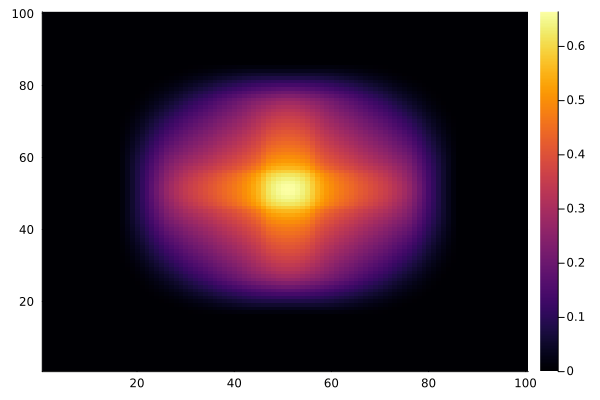

In [100]:
zblurredImg = real(ifft(fft(I) .* fft(K)))
heatmap(blurredImg)

Do you think information has been lost in this process?  Perhaps surprisingly, it has not.  You can get the original image back by *doconvolution*, which amounts to simply dividing by the FFT of the kernal, rather than multiplying. 

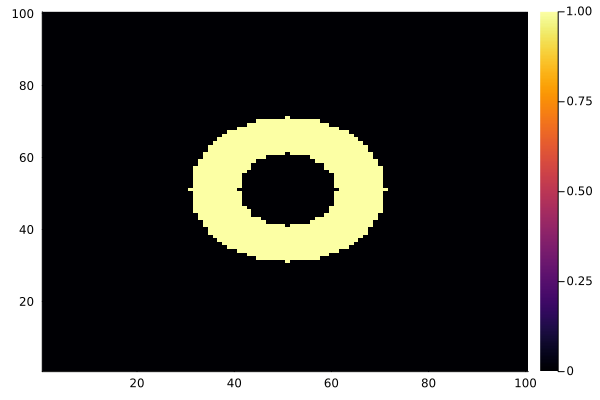

In [101]:
recoveredImg = real.(ifft(fft(blurredImg) ./ fft(K)))
heatmap(recoveredImg)

<h3>FFT as approximation to the Fourier transform.</h3>

The (continuous) Fourier transform is a sort of limit of Fourier series over a very large interval, rather than just $[0,1]$.  Given a function $f:\mathbb{R}\rightarrow \mathbb{R}$, provided it is sufficiently integrable, it's Fourier transform is defined as 
$$
\tilde f(y) = \mathcal{F}\left[f\right](y) := \int_{-\infty}^{\infty} f(x) e^{-2\pi i x y} dx.
$$
The function $f$ can be recovered from its Fourier transform $\tilde f$ via 
$$
f(x) = \int_{-\infty}^{\infty} \tilde f(y) e^{2\pi i x y} dy.
$$
Fourier transforms are very useful for e.g. solving differential equations, because of properties like 
$$
\mathcal{F}\left[\frac{df}{dx}\right](y) = \int_{-\infty}^{\infty} \frac{df}{dx} e^{-2\pi i xy} dx = (-2\pi i y) \int_{-\infty}^{\infty} f(x) e^{2\pi i x y} dx,
$$
which comes from integrating by parts in the middle expression.  This says that Fourier transformation converts derivatives into multiplication.  This reduces differential equations to algebraic equations.  We won't dwell on this point, but if it's unfamiliar you should spend some time playing with it. 

For us the big question is: Does the FFT approximate the Fourier transform?  The answer is yes, but with caveats.  The FFT of $f(x_0), f(x_0 + dx), \dots, f(x_0 + (N-1) dx)$ approximates the Fourier transform of $f(x)$ in the interval $\left[\frac{-1}{2\; dx}, \frac{1}{2\; dx}\right]$.  Outside of this range, the FFT is periodic, while the continuous Fourier transform is not.  

If you want to use FFTs to approximate Fourier transforms, you need to be careful with units.  My recommendation is this: For given sequence length $N$, use the grid `(-floor(N / 2):floor((N - 1) / 2)) ./ sqrt(N)` for sampling your functions.  The nice thing about this grid is that the FFT points which match the Fourier transform live on the same grid.  So by using this grid, you don't need to keep track of two separate grids.  

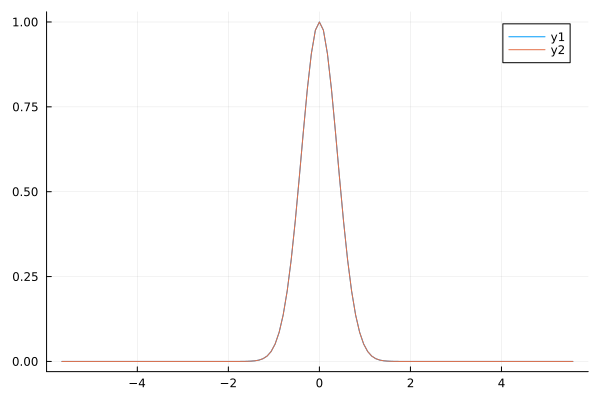

In [105]:
# Define a function whose Fourier transform you can compute analytically and compare it to the FFT output. 
N = 128 
grid = (-floor(N / 2):floor((N - 1) / 2)) ./ sqrt(N)
fs = exp.(-grid.^2 * pi)    # This function is its own Fourier transform
Fs = real.(ifftshift(fft(fftshift(fs))) ./ sqrt(N))   # The shifts are to map negative frequencies to equivalent positive frequencies and back. 
plot(grid,[fs, Fs])

<h3>Derivatives and integrals via FFT.</h3>

Fourier methods make differentiation (and integration to a lesser extent) very easy.  A derivative is just multiplication by $(-2\pi i y)$ in the Fourier domain.  Integration is a bit trickier because the result will always be periodic; so you need to apply some linear shifts to make everything work out.  

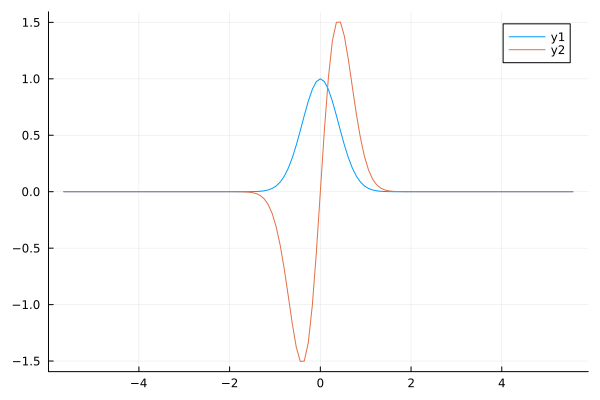

In [107]:
sft(x) = ifftshift(fft(fftshift(x)))
isft(x) = ifftshift(ifft(fftshift(x)))
dfs = real.(isft( -2pi*im * grid .* sft(fs)))
plot(grid,[fs,dfs])

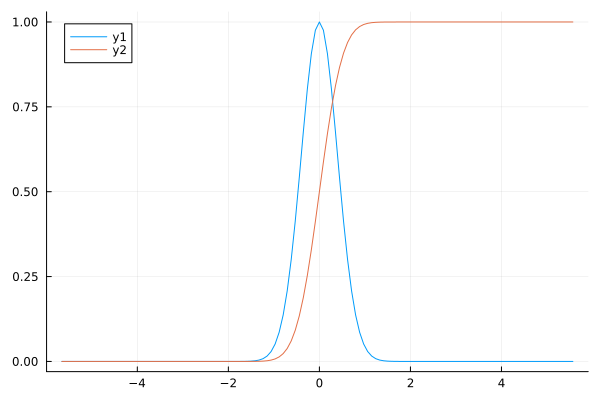

In [119]:
ifs = real.(isft( 1 ./(2pi*im * grid .+ im*eps()) .* sft(fs .- sum(fs)))) .+ (0:1/N:1-1/N) .* sum(fs) .* step(grid)
plot(grid,[fs,ifs])